We define three different functions to calculate the gestational requirements (expressed in NE per day):
1. According to AFRC 1993.
2. According to ARC 1980.
3. According to NRC (based on a model fit on data from Bell et al. 1995).

In [1]:
from math import exp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def y1(t,W=40):
    ''' AFRC 1993 (MJ NE/day) --- p. 29. '''
    Et = 10**(151.665 * (1 - exp(-0.0000576 * t)))
    Ec = 0.025 * W * Et * 0.0201 * exp(0.0000576 * t)

    return Ec

def y2(t,SBW=1):
    ''' ARC 1980 (MJ NE/day). '''
    A = 11.95
    B = 16.59
    C = 0.00334
    Y = SBW * exp(A - B * exp(-C * t))
    dYdt = B * C * exp(-C * t) * Y
    return dYdt

def y3(t, W=45):
    ''' Parameters based on fitting a quadratic equation to the data of Bell et al. 1995.
    
    The relation used here is the derivative of the quadratic equation, scaled to a calf 
    birth-weight of 45 kg. See further down in the notebook for the actual fit to the data.
    '''
    A = 0.012418
    B = 0.025013
    
    return W/45 * A*t + B


Text(0, 0.5, 'ME requirement (MJ / d)')

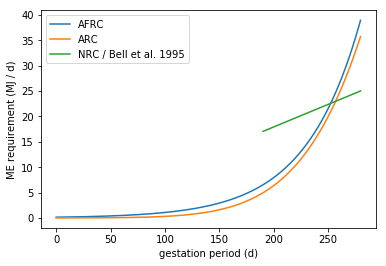

In [3]:
xs = np.linspace(0,280,360)

efficiency = 0.14
inefficiency = 1/efficiency

y1s = inefficiency*np.array([y1(x) for x in xs])
y2s = inefficiency*np.array([y2(x) for x in xs])
y3s = inefficiency*np.array([y3(x) if x >= 190 else 0 for x in xs])
y3s[y3s == 0] = None

# Plot the results
fig = plt.figure()
ax = fig.gca()

ax.plot(xs,y1s, label='AFRC')
ax.plot(xs,y2s, label='ARC')
ax.plot(xs,y3s, label='NRC / Bell et al. 1995')
ax.legend()

ax.set_xlabel('gestation period (d)')
ax.set_ylabel('ME requirement (MJ / d)')


In LIVSIM the timestep of integration is one month. To get to this temporal resolution, the relation from AFRC 1993 is used to calculate the cumulative requirements during the nth month of gestation. This approach leads to the following dilemma: the typical gestation period for cattle is in the order of 280 days. This is slightly more than 9 months, but slightly (more) less than 10 months. In LIVSIM the gestation period typically used has been 10 months, rather than 9. To check what this means for the gestational requirements in time we calculate ME requirements over a 10-month period and over a 9-month period. The outcomes of the calculations are compared with the reported requirements during the last month of gestation in Bell et al. 1995, to get an idea of the fit between model and measurements during the last stages of gestation.

As will be abundantly clear from the two graphs below, the exponential relation from AFRC 1993 leads to a considerable overestimation of gestational requirements towards the end of gestation if a gestation duration of 10 months is used.

(0, 2500)

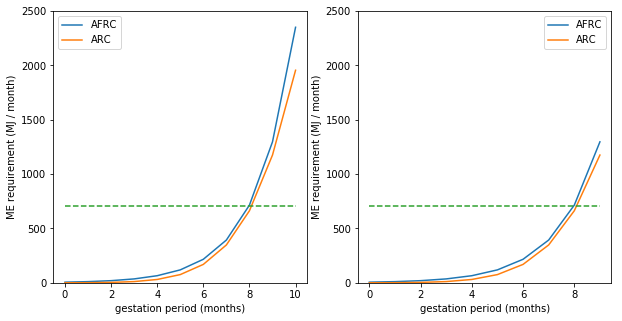

In [4]:
D_P_M = 30

# calculate gestational requirements assuming a 10-month gestation
months = np.linspace(0, 10, 11)

y1s = inefficiency*np.array([sum([y1(d) for d in range(int(m)*D_P_M, int(m+1)*D_P_M)]) for m in months])
y2s = inefficiency*np.array([sum([y2(d) for d in range(int(m)*D_P_M, int(m+1)*D_P_M)]) for m in months])

# calculate gestational requirements assuming a 9-month gestation
months_9 = np.linspace(0, 9, 10)

y1s_9 = inefficiency*np.array([sum([y1(d) for d in range(int(m)*D_P_M, int(m+1)*D_P_M)]) for m in months_9])
y2s_9 = inefficiency*np.array([sum([y2(d) for d in range(int(m)*D_P_M, int(m+1)*D_P_M)]) for m in months_9])

# mean net energy requirement for conceptus growth between day 240 and 270 of gestation (Bell et al. 1995, table 2, gravid uterus)
NE_demand_kcal = 773  # kcal / d
ME_demand_kcal = 773 / 0.14  # assuming a use efficiency of ME for gestation of 14%
ME_demand_kJ = ME_demand_kcal * 4.184  # 1 cal == 4.184 J
ME_demand_MJ_month = ME_demand_kJ / 1000 * 30.4

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(months, y1s, label='AFRC')
axes[0].plot(months, y2s, label='ARC')
axes[0].plot([0, 10], [ME_demand_MJ_month, ME_demand_MJ_month], linestyle='--')
axes[0].legend()
axes[0].set_xlabel('gestation period (months)')
axes[0].set_ylabel('ME requirement (MJ / month)')
axes[0].set_ylim([0, 2500])

axes[1].plot(months_9, y1s_9, label='AFRC')
axes[1].plot(months_9, y2s_9, label='ARC')
axes[1].plot([0, 9], [ME_demand_MJ_month, ME_demand_MJ_month], linestyle='--')
axes[1].legend()
axes[1].set_xlabel('gestation period (months)')
axes[1].set_ylabel('ME requirement (MJ / month)')
axes[1].set_ylim([0, 2500])

#### Fit of a quadratic equation to the data reported in Bell et al. 1995. J. Dairy Sci. 78(9): 1954-1961.
The data from the article have been extracted using Engauge Digitizer. The quadratic equation has been fitted both to the original data, expressed in Mcal and to the data after conversion to MJ.

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from lmfit import Minimizer, Parameters, report_fit

ModuleNotFoundError: No module named 'lmfit'

In [ ]:
# read data
data = pd.read_csv('Bell et al 1995.csv', index_col=0)

# derive x (=time) values from the index of the data-frame
time = np.array(list(data.index))

In [ ]:
data_MJ = data * 4.184

In [ ]:
%matplotlib inline
from lmfit import Model

In [6]:
def quadratic_equation(time, a, b, c):
    return a * time**2 + b * time + c

In [7]:
quadratic_model = Model(quadratic_equation)
params = quadratic_model.make_params(a=0.00159, b=-0.03520, c=-35.4)

y_gu = data['gravid_uterus']
result_gu = quadratic_model.fit(y_gu, params, time=time)

y_f = data['fetus']
result_f = quadratic_model.fit(y_f, params, time=time)

fig = plt.figure()
ax = fig.gca()

ax.plot(time, y_gu, 'ko', label='gravid uterus')
ax.plot(time, result_gu.best_fit, label='gravid uterus')

ax.plot(time, y_f, 'ko', label='fetus', markerfacecolor='w')
ax.plot(time, result_f.best_fit, label='fetus')

ax.legend()

print(result_gu.fit_report())

NameError: name 'Model' is not defined

In [8]:
quadratic_model = Model(quadratic_equation)
params = quadratic_model.make_params(a=0, b=0, c=0)

y_gu = data_MJ['gravid_uterus']
result_gu = quadratic_model.fit(y_gu, params, time=time)

y_f = data_MJ['fetus']
result_f = quadratic_model.fit(y_f, params, time=time)

fig = plt.figure()
ax = fig.gca()

ax.plot(time, y_gu, 'ko', label='gravid uterus')
ax.plot(time, result_gu.best_fit, label='gravid uterus')

ax.plot(time, y_f, 'ko', label='fetus', markerfacecolor='w')
ax.plot(time, result_f.best_fit, label='fetus')

ax.legend()

print(result_gu.fit_report())
print(result.ci_report())

NameError: name 'Model' is not defined

In [3]:
for i in range(121):
    print(i % 12)

0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
0
